This notebook features the post-run data analysis conducted on predictions generated by the eSNLI pre-trained model, specifically in the context of cosine similarity between Premise and Hypothesis.

In [7]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [8]:
df = pd.read_csv("./post-run_esnli_test_cos_sim_data.csv")

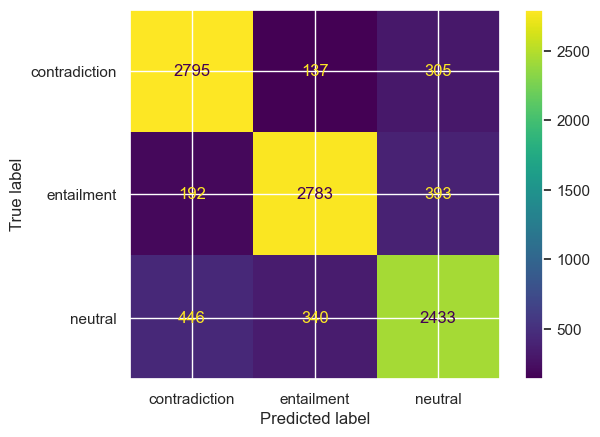

In [9]:
actual = df["gold_label"].tolist()
predicted = df["pred_label"].tolist()

confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["contradiction", "entailment", "neutral"])
cm_display.plot()
plt.show()

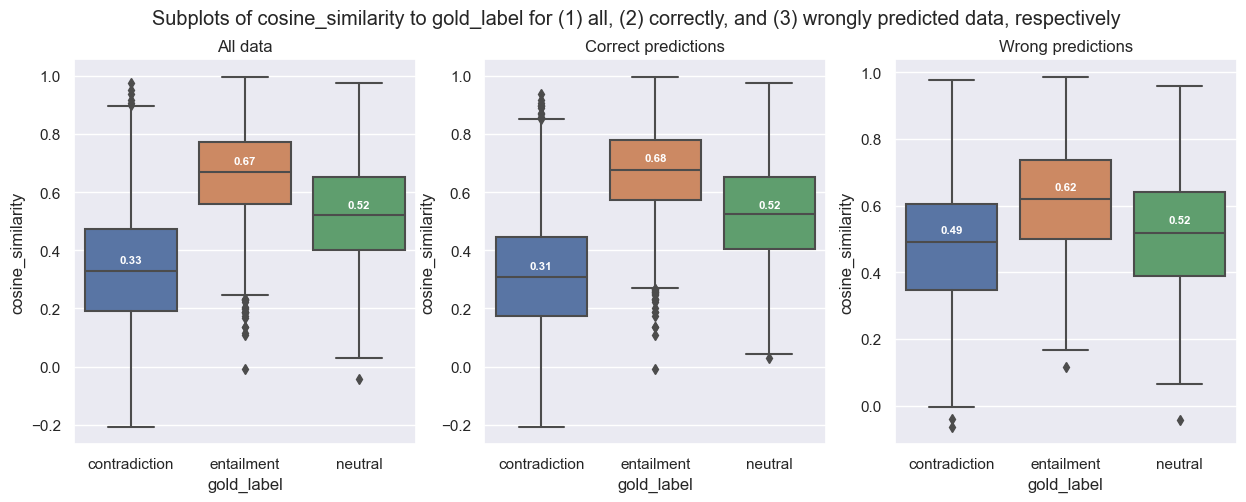

In [10]:
sns.set()
def label_medians(dataframe, boxplot, x, y):
    medians = round(dataframe.groupby([x])[y].median(),2)
    vertical_offset = dataframe[y].median() * 0.05
    for xtick in boxplot.get_xticks():
        boxplot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], horizontalalignment='center',size='x-small',color='w',weight='semibold')

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
fig.suptitle('Subplots of cosine_similarity to gold_label for (1) all, (2) correctly, and (3) wrongly predicted data, respectively')

correct_df = df[df["gold_label"] == df["pred_label"]]
wrong_df = df[df["gold_label"] != df["pred_label"]]

order=["contradiction", "entailment", "neutral"]

all_boxplot = sns.boxplot(data=df, ax=axes[0], x="gold_label", y="cosine_similarity", order=order)
axes[0].set_title('All data')
label_medians(df, all_boxplot, "gold_label", "cosine_similarity")

correct_boxplot = sns.boxplot(data=correct_df, ax=axes[1], x="gold_label", y="cosine_similarity", order=order)
axes[1].set_title('Correct predictions')
label_medians(correct_df, correct_boxplot, "gold_label", "cosine_similarity")

wrong_boxplot = sns.boxplot(data=wrong_df, ax=axes[2], x="gold_label", y="cosine_similarity", order=order)
axes[2].set_title('Wrong predictions')
label_medians(wrong_df, wrong_boxplot, "gold_label", "cosine_similarity")

# plt.savefig('cos_sim_preds.png', dpi=300)

^^^
Running the cell above outputs a figure with 3 subplots. The x-axis is the "gold_label" while the y-axis is the cosine similarity between Premise and Hypothesis. 

Subplots definition:
- 1st subplot encompasses all data and their predictions, whether correct or incorrect. 
- 2nd subplot encompasses data where the predictions are correct (i.e. "gold_label" == "pred_label").
- 3rd subplot encompasses data where the predictions are wrong (i.e. "gold_label" != "pred_label")

Data observation:
- The cosine similarity between the Premise and Hypothesis of correct predictions when compared to all data seems to be about the same. 
- Cosine similarity of wrongly predicted data with 'entailment' and 'neutral' as "gold_label" seem to also be about the same as cosine similarity observed in all data.
- However, the median cosine similarity of wrongly predicted data with 'contradiction' as "gold_label" seem to be significantly higher at 0.49 as compared to 0.33 in all data.

Data interpretation:
- This could indicate that the model has significantly more difficulty in correctly predicting contradictions where the Premise and Hypothesis have higher cosine similarity than other data.We proceed to manually inspect the data to try to figure out why contradictory sentences are much more commonly associated with an entailment prediction as opposed to a neutral prediction. 

In [11]:
contradiction_to_entailment = df[(df["gold_label"] == "contradiction") & (df["pred_label"] == "entailment")]
contradiction_to_neutral = df[(df["gold_label"] == "contradiction") & (df["pred_label"] == "neutral")]
print(f"""Contradictions wrongly predicted as entailment: {len(contradiction_to_entailment)}
Contradictions wrongly predicted as neutral: {len(contradiction_to_neutral)}""")

Contradictions wrongly predicted as entailment: 137
Contradictions wrongly predicted as neutral: 305


^^^ From running the cell above, we see that the distribution of wrongly predicted contradictions are skewed towards predicting "neutral" than predicting "entailment", with a count of 305 and 137 respectively. 

We proceed to manually inspect the data to try to figure out why contradictory sentences are more commonly associated with a neutral prediction as opposed to an entailment prediction. 

In [12]:
contradiction_to_neutral.sort_values(by='cosine_similarity', ascending=False).head(30)

,gold_label,Premise,Hypothesis,pred_label,pred_expl,Expl_1,Expl_2,Expl_3,cosine_similarity
1947,contradiction,A woman with a blue hat and blue and red jacket setting up a camera on a tripod .,A woman with a red hat sets up a camera on a tripod,neutral,a woman with a blue hat and blue and red jacket is setting up a camera on a tripod does not indicate that she is wearing a red hat,the woman ca n't wear both a red hat and a blue hat .,the woman 's had is either blue or red ; it can not be both .,if it is already set then there is no need for setting .,0.876593
3170,contradiction,"A girl is swinging , rather high , on a swing with blue ropes with lots of trees in the background .","A girl is swinging , rather high , on a swing with white ropes .",neutral,the girl is not necessarily swinging high .,blue is not white .,the swing either has blue or white ropes .,blue not same as white,0.868027
4398,contradiction,A woman holds a newspaper that says `` Real change '' .,a woman with a newspaper that says `` real change '' on the ground next to her,neutral,a woman holds a newspaper does not mean she is holding it .,if she is holding it that means it 's not on the ground .,a woman that holds a newspaper can not be the same woman with a newspaper on the ground next to her .,the woman that holds a newspaper could not have had the newspaper on the ground next to her .,0.861503
8657,contradiction,Girls giving a presentation for a school class .,The girls are watching a presentation in a classroom .,neutral,the presentation is not necessarily in a classroom .,people can not be giving a presentation and watching a presentation simultaneously .,"giving a presentation and watching a presentation , are completely different activities .",the girls would either be in front of the class giving a presentation or looking on from their seat watching others .,0.831770
3070,contradiction,a brown dog coming out of an orange and yellow tunnel,A brown dog dancing out of a orange and yellow tunnel .,neutral,coming out of an orange and yellow tunnel does not imply dancing out of the tunnel .,the dog can not be both coming and dancing out of the yellow tunnel .,coming and dancing are not the same thing .,a dog dancing out could not have been coming out .,0.830999
9211,contradiction,A woman is leaning against a wall with her shoe off .,"A woman is standing in high heels , leaning against a wall .",neutral,a woman is leaning against a wall with her shoe off does not indicate that she is standing in high heels .,the woman may either be leaning or standing .,one can not be in high heels and with her shoe off at the same time .,"in 1st sentence it is mentioned that women leaning against a wall with her shoe off but , in 2nd sentence woman is standing in high heels and leaning against a wall .",0.806669
5179,contradiction,"A man in a helmet and protective gear driving a go kart , numbered 65 , on a narrow paved road .","A man driving a go kart , numbered 34 , on a narrow dirt road .",neutral,not all go are a .,the go kart is either numbered or ; the road can not be paved and a dirt road at the same time .,"a man driving on a go kart , numbered and numbered can not be the same .","the go kart is either numbered or , not both .",0.804753
1841,contradiction,Two workers with leaf blowers blow orange leaves off patches of grass next to a wet sidewalk .,Two workers with leaf blowers blow leaves at each other for fun,neutral,just because workers are using a blower blow does n't mean they are doing so for fun .,leaf blowers are not used for fun .,the workers can not be blowing leaves at each other while blowing leaves off patches of grass .,these could be the same incident ... just that blowing them off the patches of grass could later result in where and why they were blown ; technically ... it is the intent in question,0.787606
2411,contradiction,A man leads the way in a race .,The man is last place in the race .,neutral,the man is not necessarily in a race .,the man is e

^^ From running the cell above, manual inspection of the 30 entries with highest cosine similarities where contradictory sentences are predicted as neutral, a few observations can be made:
1. The model misidentifies the important contradictory phrases in the Premise and Hypothesis that should be compared. Some examples are as follows:
- Index 3170: Model does not identify the key contradictory phrases: "swing with blue ropes" and "swing with white ropes".
- Index 4398: Model does not identify the key contradictory phrases: "holds" and "on the ground next to her".
- Index 8657: Model does not identify the key contradictory phrases: "giving a presentation" and "watching a presentation".

2. The model correctly identifies the important contradictory phrases in the Premise and Hypothesis that should be compared, yet does not think they are contradictory, but rather, unrelated. Some examples are as follows:
- Index 1947: Model identifies the key contradictory phrases: "woman with a blue hat" and "woman with a red hat", but mentions that the former "does not indicate" the latter.
- Index 5531: Model identifies the key contradictory phrases: "traveling in a small wooden boat" and "waiting for a larger boat", but mentions that the former "does not mean" the latter.
- Index 6957: Model identifies the key contradictory phrases: "skiing" and "bundled up", but mentions that the former "does not imply" the latter.

3. Some of the data are just dirty and should not have been used as input. Some examples are as follows:
- Index 3070: A dog "coming out" of a tunnel can also be "dancing out" of the tunnel. Both statements can be true, and thus, should not have been labelled as "contradiction".
- Index 1841: Workers who "blow orange leaves off patches of grass next to a wet sidewalk" can also "blow leaves at each other for fun", as the workers could have blown leaves from patches of grass at each other for fun. Since both statements can be true, this should not have been labelled as "contradiction".

END